In [5]:
import warnings
import numpy as np
import gc
import json
import h5py
import threading
import time
import seaborn as sn
import pandas as pd

import tensorflow as tf
from keras.utils import Sequence
from keras.utils.data_utils import get_file
from keras.preprocessing import sequence
from keras.preprocessing.sequence import _remove_long_seq
from keras.models import Sequential
from keras.layers import Embedding, Input, Dense, Dropout, CuDNNLSTM, Bidirectional
from keras import metrics
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt


gpu_options = tf.GPUOptions(
    per_process_gpu_memory_fraction=0.65, allow_growth=False)
config = tf.ConfigProto(intra_op_parallelism_threads=16,
                        inter_op_parallelism_threads=16, allow_soft_placement=True, gpu_options=gpu_options)
session = tf.Session(config=config)
K.set_session(session)


In [6]:
def load_vocab():
    with open('data/ams_word_nomath_index.json') as json_data:
        return json.load(json_data)

def load_index_vocab():
    index_vocab = {}
    with open('data/ams_word_nomath_index.json') as json_data:
        for word, index in json.load(json_data).items():
            index_vocab[index] = word
    return index_vocab

    
def load_glove():
    glove = {}
    with open('data/glove.model.nomath.txt') as glove_data:
        for line in glove_data:
            items = line.split()
            key = items[0]
            glove[key] = np.asarray(items[1:], dtype='float32')
    return glove


def build_embedding_layer(with_input=False, maxlen=480, vocab_dim=300, mask_zero=True):
    print("-- loading word embeddings, this may take a couple of minutes...")
    index_dict = load_vocab()
    word_vectors = load_glove()
    # adding 1 to account for 0th index (for masking)
    n_symbols = len(index_dict) + 1
    print("-- known dictionary items: ", n_symbols)
    embedding_weights = np.zeros((n_symbols, vocab_dim))
    for word, index in index_dict.items():
        embedding_weights[index, :] = word_vectors[word]
    print("-- embeddings ")
    if not with_input:
        embedding_layer = Embedding(
            mask_zero=mask_zero,
            output_dim=vocab_dim, input_dim=n_symbols, input_length=maxlen, trainable=False, weights=[embedding_weights])
        return embedding_layer
    else:
        # define inputs here
        input_1 = Input(shape=(maxlen,), dtype='int32')
        embedding_layer = Embedding(
            weights=[embedding_weights],
            mask_zero=mask_zero,
            output_dim=vocab_dim, input_dim=n_symbols, input_length=maxlen, trainable=False)(input_1)
        return (embedding_layer, input_1)


In [7]:
# Input data is obtained via batch loading from HDF5
class DataGenerator(Sequence):
    def __init__(self, batch_size=128, mode="train", dim=480,
             n_classes=13, x_hf = None, y_hf = None, shuffle=False):
        'Initialization'
        self.x_hf = x_hf
        self.y_hf = y_hf
        self.mode = mode
        self.total_len = self.y_hf.shape[0]
        self.validation_len = int(np.ceil(0.1 * self.total_len))
        self.training_len = self.total_len - self.validation_len
        if self.mode == "validation":
            self.data_len = self.validation_len
            self.list_IDs = np.arange(self.training_len, self.total_len)
        else:
            self.data_len = self.training_len
            self.list_IDs = np.arange(0,self.training_len+1)
            
        self.dim = dim
        self.batch_size = batch_size
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end() 

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples,  dim)
        # Initialization
        X = np.empty((self.batch_size, self.dim), dtype=int)
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self.x_hf[ID]
            # Store class
            y[i] = self.y_hf[ID]
        
        return X, y
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

batch_size = 128
# Parameters
data_hf = h5py.File("data/confusion_free_nomath.hdf5", 'r')
generator_params = {
    'batch_size': batch_size,
    'n_classes': 13,
    'shuffle': False,
    'x_hf': data_hf['x_train'],
    'y_hf': data_hf['y_train']
}
# Generators
training_generator = DataGenerator(**generator_params)
validation_generator = DataGenerator(mode="validation", **generator_params)




In [8]:
# preparing word embeddings
# Takes 10 minutes to recompute, memoizing here for the v4 49 class variant:
# class_weights = compute_class_weight('balanced', np.unique(training_generator.y_hf), training_generator.y_hf)
# np.set_printoptions(precision=32, suppress=True)
# print(class_weights)

class_weights = [
  0.7483095715566197, 4.754501247119297,  1.922516556926298,
  1.1549558601260375, 2.668737662773207,  1.1207340910837413,
  492.8275989186532,  0.3638972379781621, 0.20817024795949343,
  13.798952339173741, 29.327446829514418,  1.205880584288014,
  3.2184743461345864 ]
# 08.2018 (subformula lexemes)
# Analyzing the arxiv dataset seems to indicate 
#   a maxlen of 960 is needed to fit 99.2% of the data
#   a maxlen of 480 fits 96.03%, and a maxlen of 300 covers 90.0% of paragraphs
maxlen = 480
n_classes = 13
layer_size = 128  # ~maxlen // 4

In [9]:
embedding_layer = build_embedding_layer(maxlen=maxlen, mask_zero=False)

-- loading word embeddings, this may take a couple of minutes...
-- known dictionary items:  757203
-- embeddings 


In [10]:
model_file = "nomath_bilstm%d_batch%d_cat%d_gpu" % (
    layer_size, batch_size, n_classes)

# Checkpoints: 1) save best model at epoch end, 2) stop early when metric stops improving
checkpoint = ModelCheckpoint(model_file+"-checkpoint.h5",
                             monitor='val_weighted_sparse_categorical_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

earlystop = EarlyStopping(monitor='val_weighted_sparse_categorical_accuracy',
                          min_delta=0.001,
                          patience=3,
                          restore_best_weights=True,
                          verbose=0, mode='auto')


In [12]:
# BiLSTM Model Setup
print("-- setting up model layout...")
use_dropout = True

model = Sequential()
model.add(embedding_layer)
if use_dropout:
    model.add(Dropout(0.2))

model.add(Bidirectional(CuDNNLSTM(layer_size, return_sequences=True)))
if use_dropout:
    model.add(Dropout(0.2))

model.add(Bidirectional(CuDNNLSTM(layer_size // 2, return_sequences=True)))
if use_dropout:
    model.add(Dropout(0.1))

model.add(CuDNNLSTM(layer_size // 2))
if use_dropout:
    model.add(Dropout(0.1))

model.add(Dense(n_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              weighted_metrics=[metrics.sparse_categorical_accuracy])

-- setting up model layout...


In [11]:
from keras.models import load_model
resume_filename = model_file+"-checkpoint.h5"
model = load_model(resume_filename)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              weighted_metrics=[metrics.sparse_categorical_accuracy])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [12]:
# Print model summary
print(model.summary())
# Perform training
print('-- training model...')
# TODO: How can we make this work with more workers? HDF5 is not thread-safe for reads...
# maybe use the unpacked .txt files and map them through the dictionary each time? Unsure... 
# On a single CPU worker: 2.5 hours per epoch for the full data, with the main BiLSTM model.
model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    workers = 1,
    use_multiprocessing=False,
    class_weight=class_weights,
    epochs=50,
    verbose=1,
    callbacks=[checkpoint, earlystop])

print("-- saving model to disk : %s " % model_file)
model.save(model_file+'_notebook.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 480, 300)          227160900 
_________________________________________________________________
dropout_1 (Dropout)          (None, 480, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 480, 256)          440320    
_________________________________________________________________
dropout_2 (Dropout)          (None, 480, 256)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 480, 128)          164864    
_________________________________________________________________
dropout_3 (Dropout)          (None, 480, 128)          0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 64)                49664     
__________

In [9]:
# from keras.models import load_model
# model = load_model(model_file+"_notebook.h5")

In [13]:
print("Per-class test measures:")
y_pred = model.predict_classes(data_hf['x_test'], verbose=1, batch_size=batch_size)
print(classification_report(data_hf['y_test'], y_pred))

Per-class test measures:
2005303/2005303 [==============================] - 993s 495us/step
              precision    recall  f1-score   support

           0       0.93      0.94      0.94    206138
           1       0.99      1.00      0.99     32444
           2       0.85      0.79      0.82     80235
           3       0.88      0.87      0.87    133559
           4       0.78      0.48      0.60     57800
           5       0.87      0.89      0.88    137637
           6       0.87      0.81      0.84       313
           7       0.91      0.93      0.92    423895
           8       0.93      0.97      0.95    740999
           9       0.89      0.75      0.82     11178
          10       0.75      0.70      0.72      5259
          11       0.77      0.71      0.74    127919
          12       0.82      0.73      0.77     47927

   micro avg       0.90      0.90      0.90   2005303
   macro avg       0.87      0.81      0.84   2005303
weighted avg       0.90      0.90      0.9

In [14]:
np.set_printoptions(precision=2)
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        annot = True
        print("Normalized confusion matrix")
    else:
        annot = False
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(50,40))
    df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
    sn.set(font_scale=1.4)#for label size
    sn.heatmap(df_cm, annot=annot)

Confusion matrix, without normalization


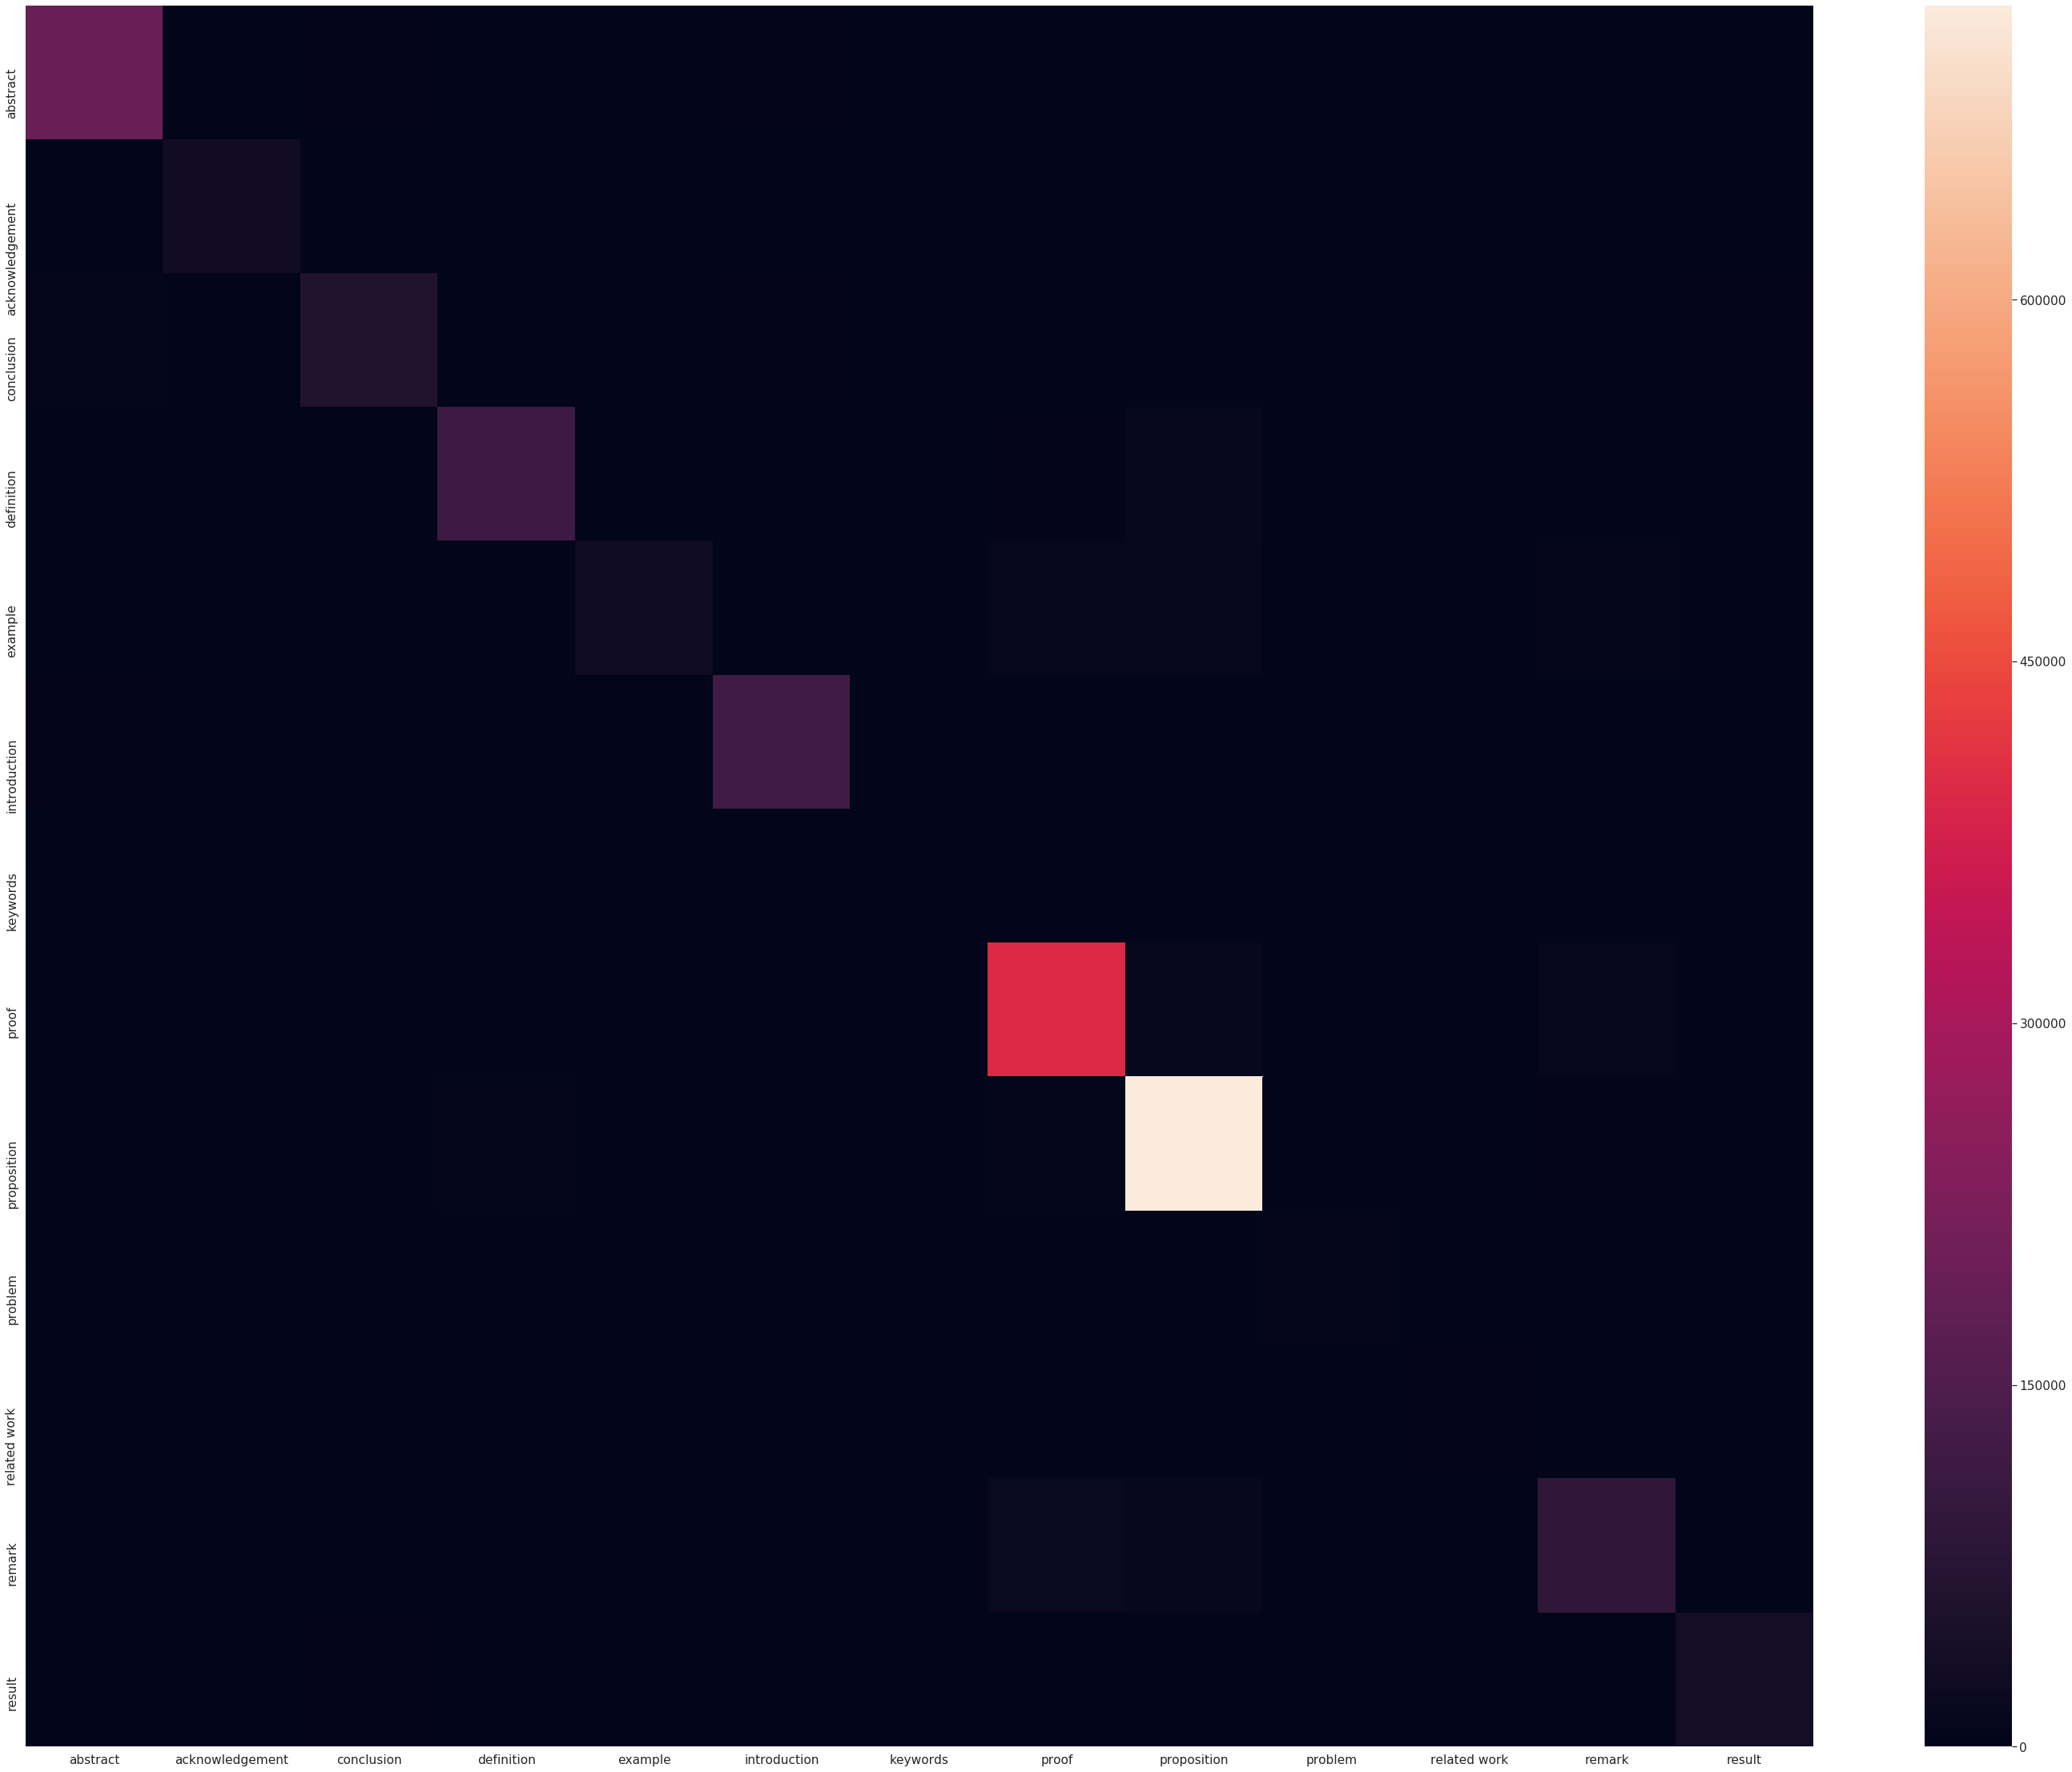

In [15]:
# Plot non-normalized confusion matrix
class_names = [
    'abstract', 'acknowledgement', 'conclusion', 'definition', 'example',
    'introduction', 'keywords', 'proof', 'proposition', 'problem', 'related work', 'remark', 'result']

plot_confusion_matrix(data_hf['y_test'], y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix


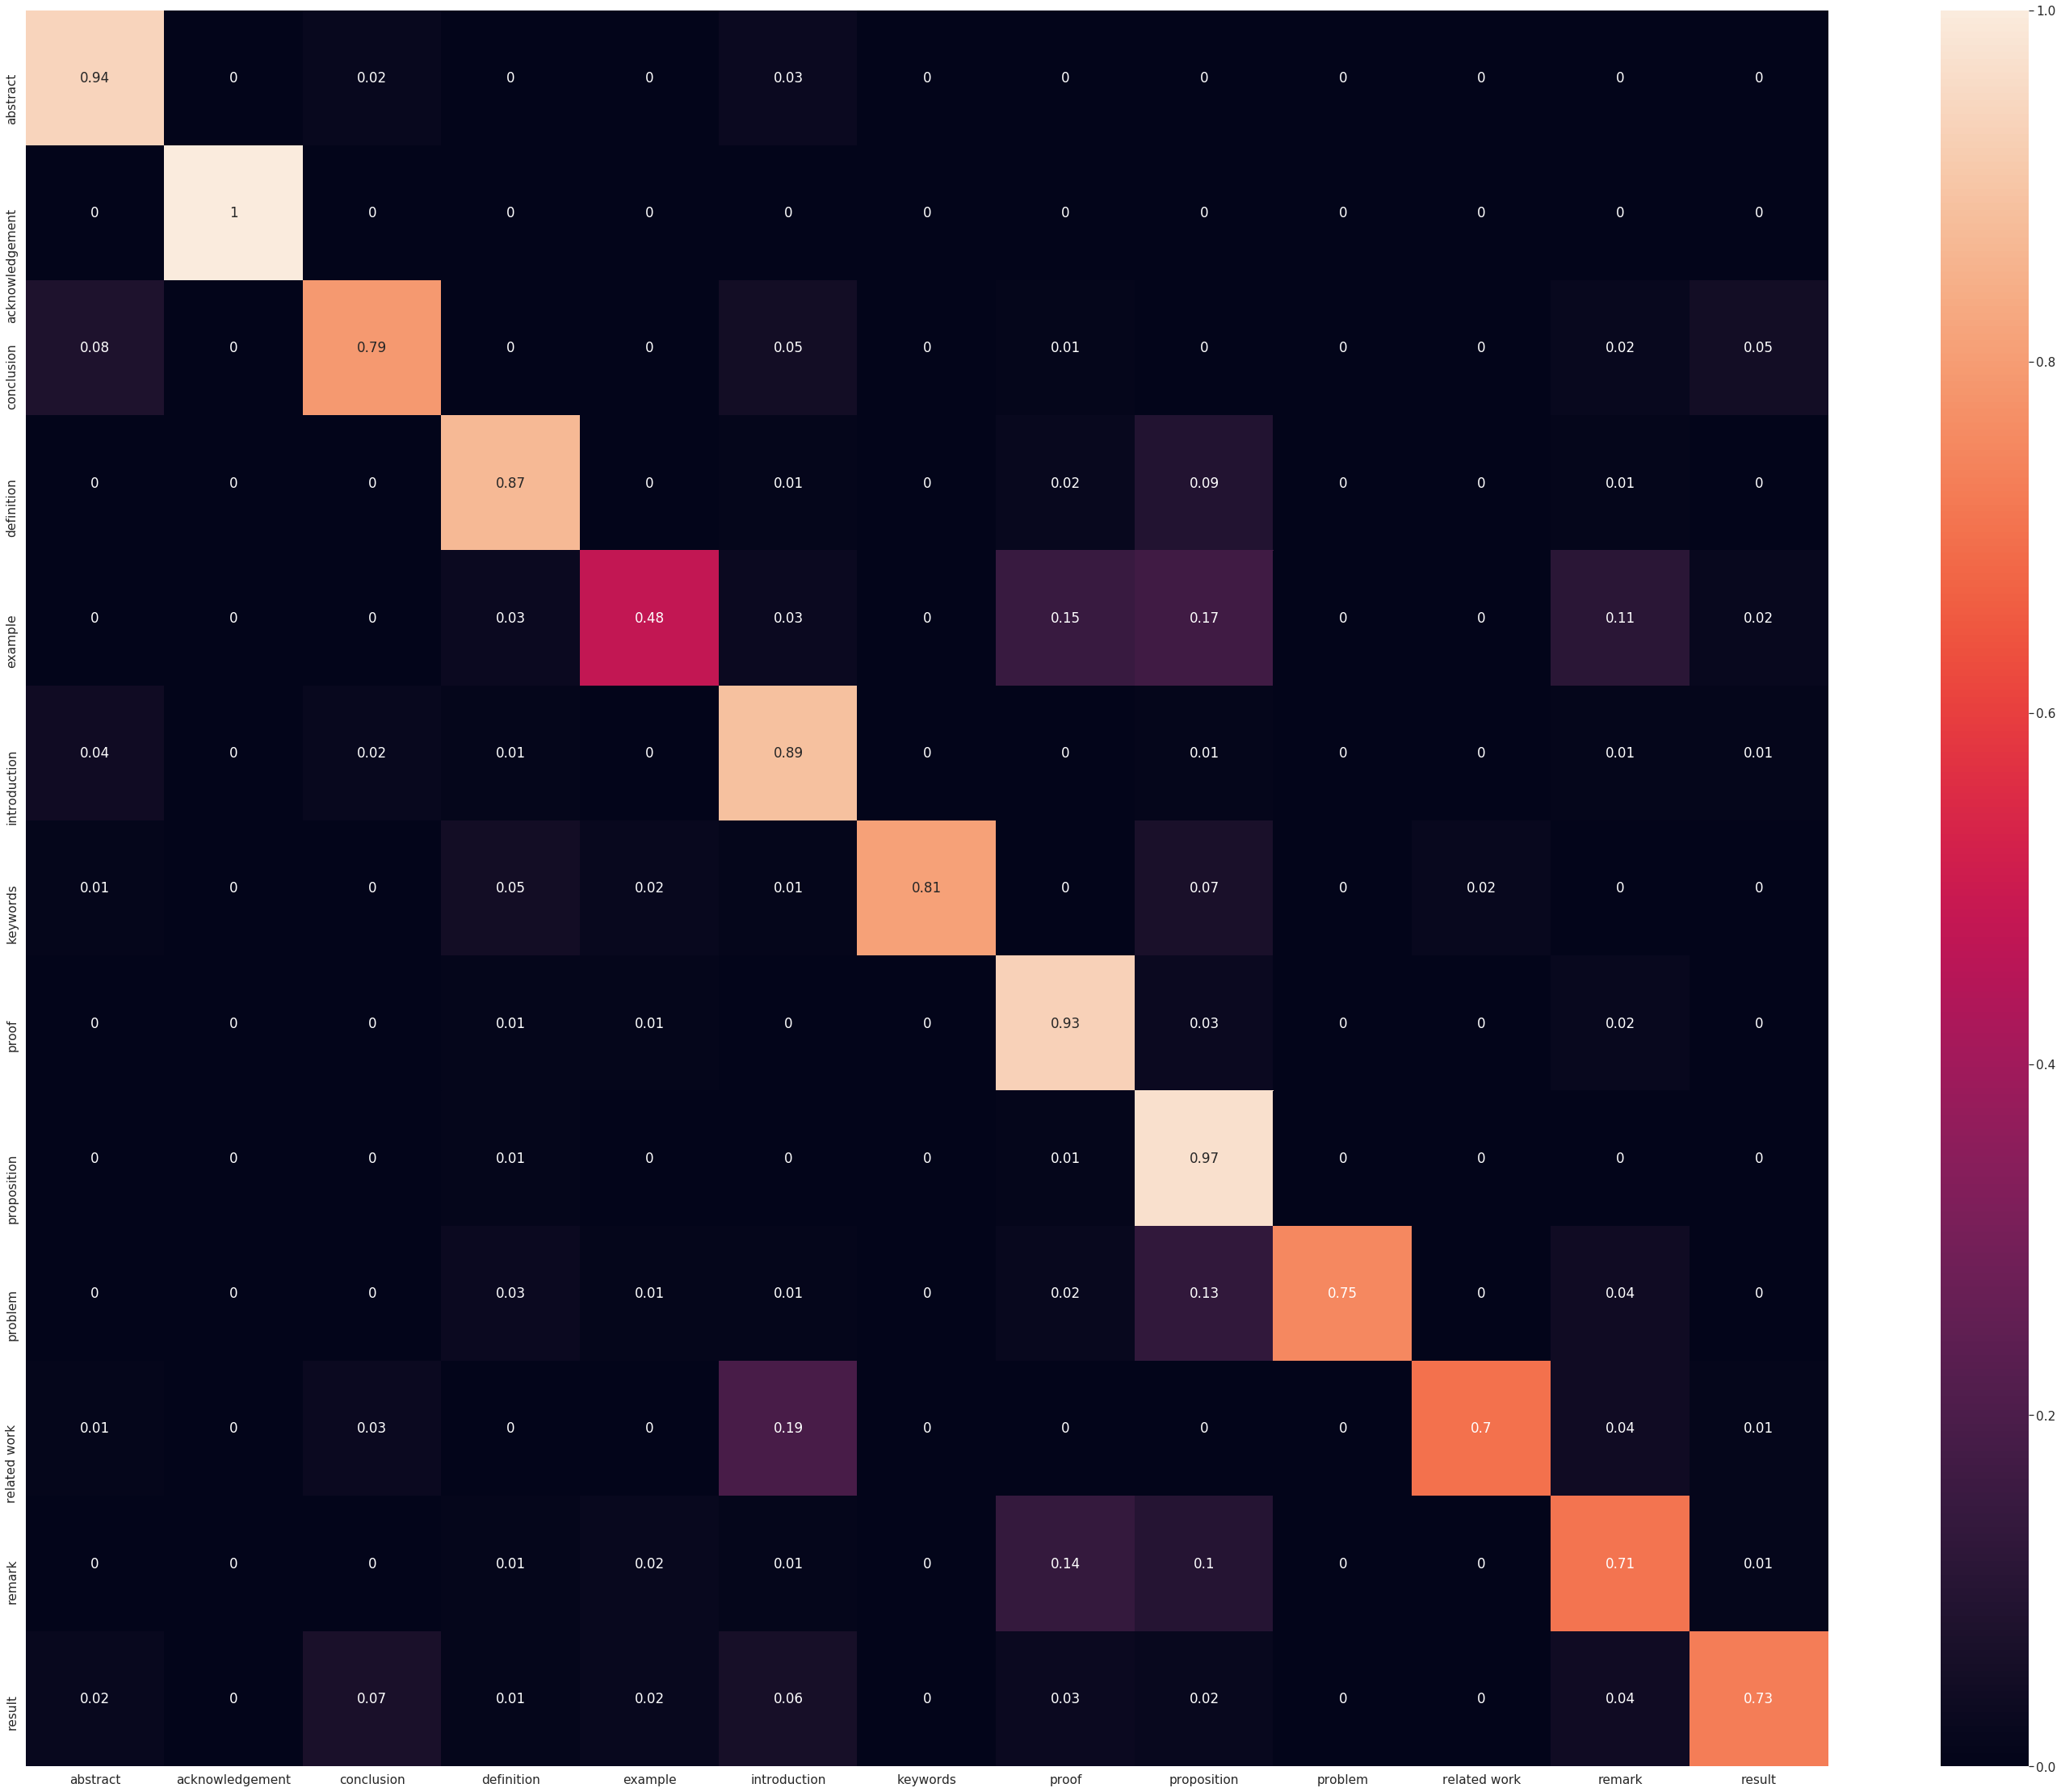

In [16]:
# Plot normalized confusion matrix
plot_confusion_matrix(data_hf['y_test'], y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

# Discussion

Converges in 9 epochs on 8 million paragraphs in training (10% of which used for validation, 90% for training), then tested on a separate 2 million paragraphs set.

## Per-class test measures:
```
Per-class test measures:
2005303/2005303 [==============================] - 993s 495us/step
              precision    recall  f1-score   support

           0       0.93      0.94      0.94    206138
           1       0.99      1.00      0.99     32444
           2       0.85      0.79      0.82     80235
           3       0.88      0.87      0.87    133559
           4       0.78      0.48      0.60     57800
           5       0.87      0.89      0.88    137637
           6       0.87      0.81      0.84       313
           7       0.91      0.93      0.92    423895
           8       0.93      0.97      0.95    740999
           9       0.89      0.75      0.82     11178
          10       0.75      0.70      0.72      5259
          11       0.77      0.71      0.74    127919
          12       0.82      0.73      0.77     47927

   micro avg       0.90      0.90      0.90   2005303
   macro avg       0.87      0.81      0.84   2005303
weighted avg       0.90      0.90      0.90   2005303
```

In [17]:
# Let's collect some misclassification examples
# Traverses the entire test set, takes ~5-10 minutes
confusion_examples = {}
correct_examples = {}

confusion_target = 12 * 11
correct_target = 12

confusion_collected = 0
correct_collected = 0
index = 0
max_index = data_hf['y_test'].shape[0]

while index < max_index and confusion_collected < confusion_target or correct_collected < correct_target:
    pred_label = y_pred[index]
    true_label = data_hf['y_test'][index]
    
    if true_label == pred_label:
        if not (true_label in correct_examples):
            correct_examples[true_label] = data_hf['x_test'][index]
            correct_collected += 1
#             print("collected correct: %d ; wrong: %d" % (correct_collected,confusion_collected))
    else:
        if not (true_label in confusion_examples):
            confusion_examples[true_label] = {}
        if not (pred_label in confusion_examples[true_label]):
            confusion_examples[true_label][pred_label] = data_hf['x_test'][index]
            confusion_collected += 1
#             print("collected correct: %d ; wrong: %d" % (correct_collected,confusion_collected))
    index+=1

In [18]:
from IPython.display import HTML, display
import tabulate

vocab = load_index_vocab()  
classification_report = [["True Label", "Predicted Label", "Content"]]
for (label, example) in sorted(correct_examples.items()):
    text = " ".join([vocab[wordidx] if wordidx != 0 else '' for wordidx in example])
    classification_report.append([class_names[label],class_names[label], text])
for (true_label, wrong_examples) in sorted(confusion_examples.items()):
    for (confused_label, wrong_example) in sorted(wrong_examples.items()):
        text = " ".join([vocab[wordidx] if wordidx != 0 else '' for wordidx in wrong_example])
        classification_report.append([class_names[true_label],class_names[confused_label], text])
        
display(HTML(tabulate.tabulate(classification_report, tablefmt='html')))


True Label,Predicted Label,Content
abstract,abstract,theories of gravity invariant under those diffeomorphisms generated by transverse vectors are considered such theories are dubbed transverse and differ from general relativity in that the determinant of the metric is a transverse scalar we comment on diverse ways in which these models can be constrained using a variety of observations generically an additional scalar degree of freedom mediates the interaction so the usual constraints on scalar tensor theories have to be imposed if the purely gravitational part is einstein hilbert but the matter action is transverse the models predict that the three a priori different concepts of mass gravitational active and gravitational passive as well as inertial are not equivalent anymore these transverse deviations from general relativity are therefore tightly constrained actually correlated with existing bounds on violations of the equivalence principle local violations of newtons third law and or violation of local position invariance
acknowledgement,acknowledgement,we acknowledge the assistance of yun and anthony d turner of nasas jet propulsion laboratory who fabricated the bolocam science array toshiro of the jpl electronic packaging group who wirebonded the array marty gould of zen machine and ricardo paniagua and the caltech pma gps instrument shop who fabricated much of the bolocam hardware carole tucker of cardiff university who tested metal mesh reflective filters used in bolocam ben knowles of the university of colorado who contributed to the software pipeline the day crew and hilo staff of the caltech submillimeter observatory who provided invaluable assistance during commissioning and data taking for this survey data set high school teacher tobias jacoby and high school students jonathon graff gloria lee and dalton sargent who helped as summer research assistants and kathy deniston who provided effective administrative support at caltech bolocam was constructed and commissioned using funds from nsf ast NUM nsf ast NUM nsf ast NUM nsf ast NUM and nsf ast NUM j sayers and g laurent were partially supported by nasa graduate student research fellowships j sayers was partially supported by a nasa postdoctoral program fellowship j aguirre was partially supported by a jansky postdoctoral fellowship and s golwala was partially supported by a r a millikan postdoctoral fellowship at caltech the research described in this paper was carried out at the jet propulsion laboratory california institute of technology under a contract with the national aeronautics and space administration
conclusion,conclusion,we have combined mid ir photometry from spitzer irac with data from 2mass to provide a sensitive photometric census of objects towards the north america and pelican nebulae we have used irac color and magnitude diagnostics to identify more than NUM sources with infrared excess characteristic of young stars surrounded by a disk
definition,definition,let be a prime finite field we denote by the order generalized reed muller code with variables this is a linear code over whose codewords are evaluations of polynomials over in variables of total degree at most
example,example,we illustrate the previous procedure with an example taken from the theory of electrical networks in particular we consider the lc switching network in citationelement see also citationelement whose dynamical equation is given by where and are positive parameters depending the inductances and capacitances of the electrical network the vector represents voltages and currents in the network and is a switching control variable which takes values in to make the discussion concrete we choose the parameters and so that the set of available matrices is the solution of ref is where is the solution of the matrix equation
introduction,introduction,the family of distributions proposed by birnbaum and saunders NUM also known as the fatigue life distribution has been widely applied 

In [19]:
import csv
with open('nomath_classification_examples.csv', 'w') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(classification_report)
writeFile.close()


### Scratch

Interrupted run:
```
-- training model...
WARNING:tensorflow:From /home/deyan/.local/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
56399/56399 [==============================] - 9275s 164ms/step - loss: 0.4399 - weighted_sparse_categorical_accuracy: 0.8627 - val_loss: 0.3633 - val_weighted_sparse_categorical_accuracy: 0.8855

Epoch 00001: val_weighted_sparse_categorical_accuracy improved from -inf to 0.88548, saving model to nomath_bilstm128_batch128_cat13_gpu-checkpoint.h5
Epoch 2/50
56399/56399 [==============================] - 9261s 164ms/step - loss: 0.3439 - weighted_sparse_categorical_accuracy: 0.8929 - val_loss: 0.3508 - val_weighted_sparse_categorical_accuracy: 0.8902

Epoch 00002: val_weighted_sparse_categorical_accuracy improved from 0.88548 to 0.89017, saving model to nomath_bilstm128_batch128_cat13_gpu-checkpoint.h5
Epoch 3/50
56399/56399 [==============================] - 9309s 165ms/step - loss: 0.3325 - weighted_sparse_categorical_accuracy: 0.8961 - val_loss: 0.3463 - val_weighted_sparse_categorical_accuracy: 0.8913

Epoch 00003: val_weighted_sparse_categorical_accuracy improved from 0.89017 to 0.89128, saving model to nomath_bilstm128_batch128_cat13_gpu-checkpoint.h5
Epoch 4/50
53575/56399 [===========================>..] - ETA: 7:25 - loss: 0.3249 - weighted_sparse_categorical_accuracy: 0.8984
```